In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv('data/Retail_data_cleaned.csv')

In [3]:
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date,Time,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010-12-01,08:26:00,15.30
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,2010-12-01,08:26:00,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,20.34


# Data Preparation


In [4]:
#Set the analysis date
df['Date'] = pd.to_datetime(df['Date'])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397884 entries, 0 to 397883
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  int64         
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   UnitPrice    397884 non-null  float64       
 5   CustomerID   397884 non-null  float64       
 6   Country      397884 non-null  object        
 7   Date         397884 non-null  datetime64[ns]
 8   Time         397884 non-null  object        
 9   TotalAmount  397884 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(4)
memory usage: 30.4+ MB


In [6]:
#set the analysis date 
analysis_date = df['Date'].max() + pd.Timedelta(days = 1)

In [7]:
# Group by CustomerID and calculate metrics.
customer_metrics = df.groupby('CustomerID').agg({
    'Date': lambda x: (analysis_date -x.max()).days, #recency
    'InvoiceNo': 'count', #frequency
    'TotalAmount': 'sum', #Monetary
    })

In [8]:
customer_metrics.columns = ['Recency','Frequency', 'Monetary']

# Perform analysis and visualizations

In [9]:
#RFM Calculations
r_labels = range(4,0,-1)
f_labels = range(1,5)
m_labels = range(1,5)

customer_metrics['R_Quartile'] = pd.qcut(customer_metrics['Recency'], q=4, labels =r_labels)
customer_metrics['F_Quartile'] = pd.qcut(customer_metrics['Frequency'], q =4, labels = f_labels)
customer_metrics['M_Quartile'] = pd.qcut(customer_metrics['Monetary'],  q=4, labels =m_labels)

customer_metrics['RFM_Score'] = customer_metrics['Recency'].astype(str) + customer_metrics['Frequency'].astype(str) + customer_metrics['Monetary'].astype(str)


In [10]:
print(customer_metrics['RFM_Score'].describe())

count            4338
unique           4338
top       43701837.28
freq                1
Name: RFM_Score, dtype: object


In [11]:
#Convert RFM_Score to numeric
customer_metrics['RFM_Score'] = customer_metrics['RFM_Score'].apply(lambda x: int(float(x)))

# Analyze the range of RFM scores
min_rfm_score = customer_metrics['RFM_Score'].min()
max_rfm_score = customer_metrics['RFM_Score'].max()
print(f'RFM Score ranges from {min_rfm_score} to {max_rfm_score}')

RFM Score ranges from 4341 to 101400117379


In [12]:
def segment_customers(row):
    r, f, m = int(row['R_Quartile']), int(row['F_Quartile']), int(row['M_Quartile'])
    
    if r == 4 and f >= 3 and m >= 3:
        return 'Best Customers'
    elif r >= 3 and f >= 3:
        return 'Loyal Customers'
    elif r == 1 and (f == 1 or m == 1):
        return 'Lost Customers'
    elif f == 1 and m == 1:
        return 'Low-Value Customers'
    else:
        return 'Other'

In [13]:

# Apply the segmentation function
customer_metrics['Customer_Segment'] = customer_metrics.apply(segment_customers, axis=1)

# Display the segmentation result
print(customer_metrics[['RFM_Score', 'Customer_Segment']])

            RFM_Score     Customer_Segment
CustomerID                                
12346.0     326177183       Lost Customers
12347.0      31824310       Best Customers
12348.0      76311797                Other
12349.0      19731757      Loyal Customers
12350.0      31117334       Lost Customers
...               ...                  ...
18280.0      27810180       Lost Customers
18281.0        181780       Lost Customers
18282.0        812178  Low-Value Customers
18283.0      47562094       Best Customers
18287.0      43701837      Loyal Customers

[4338 rows x 2 columns]


# Visualization of the data

Text(0.5, 1.0, 'Distribution of Customer Segments')

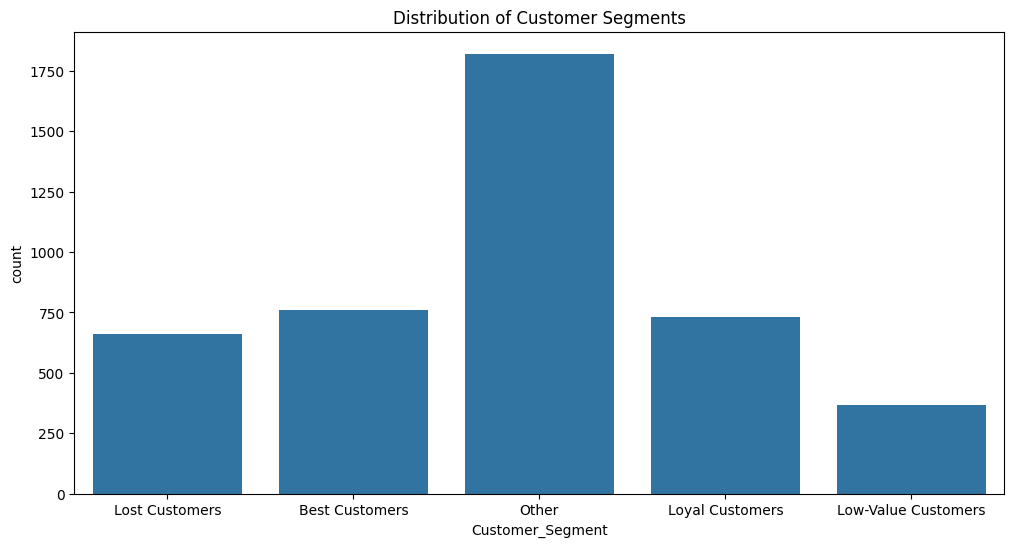

In [14]:
# 1. Distribution of RFM scores
plt.figure(figsize=(12, 6))
sns.countplot(x='Customer_Segment', data=customer_metrics)
plt.title('Distribution of Customer Segments')

Text(0.5, 1.0, 'Recency vs Frequency by Customer Segment')

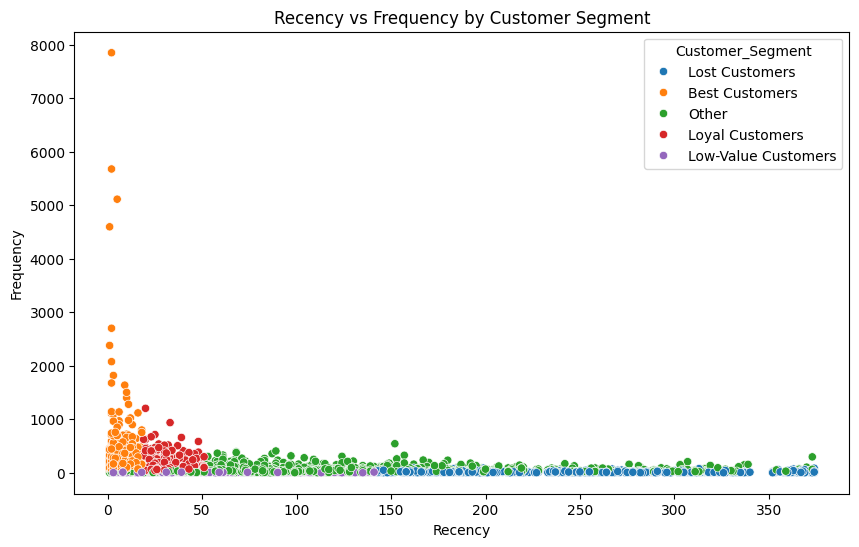

In [15]:
#2. Recency vs Frequency scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Recency', y='Frequency', hue='Customer_Segment', data=customer_metrics)
plt.title('Recency vs Frequency by Customer Segment')

Text(0, 0.5, 'Average Monetary Value')

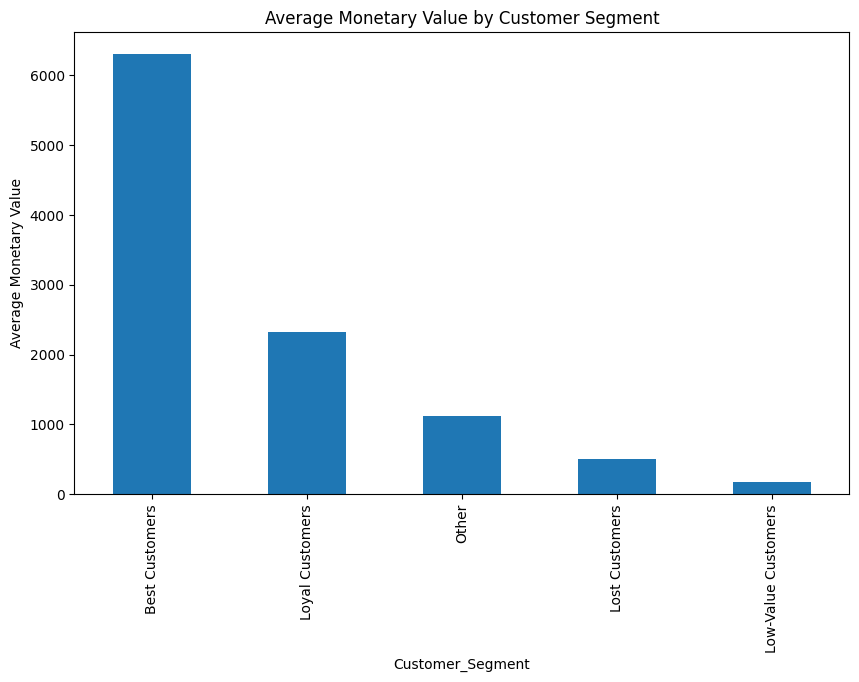

In [16]:
# 3. Average Monetary Value by Customer Segment
avg_monetary = customer_metrics.groupby('Customer_Segment')['Monetary'].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
avg_monetary.plot(kind='bar')
plt.title('Average Monetary Value by Customer Segment')
plt.ylabel('Average Monetary Value')

C:\Users\Administrator\AppData\Local\Temp\ipykernel_3412\2177949428.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_revenue = df.set_index('Date').resample('M')['TotalAmount'].sum()


Text(0, 0.5, 'Total Revenue')

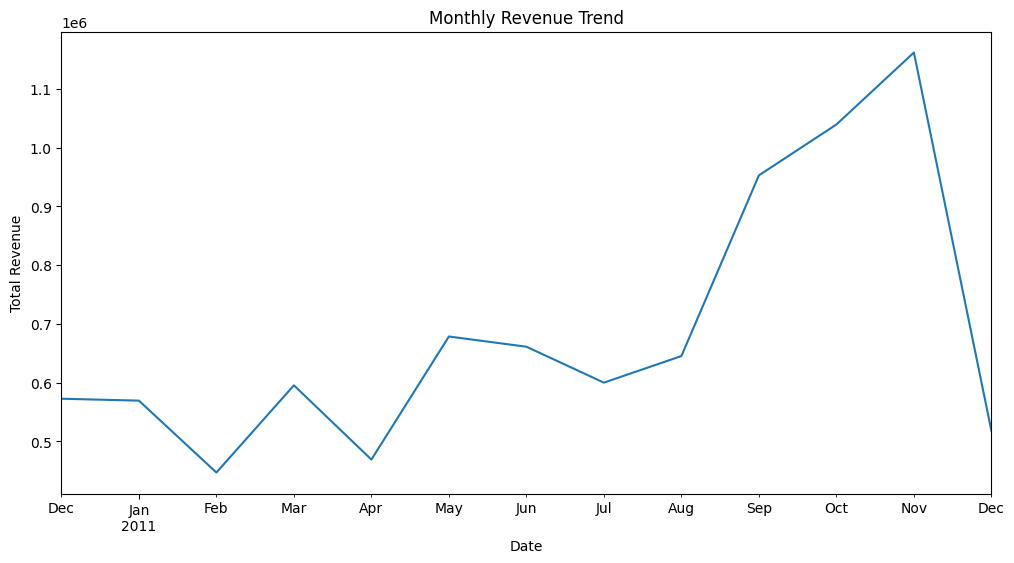

In [17]:
# 4. Monthly revenue trend
monthly_revenue = df.set_index('Date').resample('M')['TotalAmount'].sum()
plt.figure(figsize=(12, 6))
monthly_revenue.plot()
plt.title('Monthly Revenue Trend')
plt.xlabel('Date')
plt.ylabel('Total Revenue')

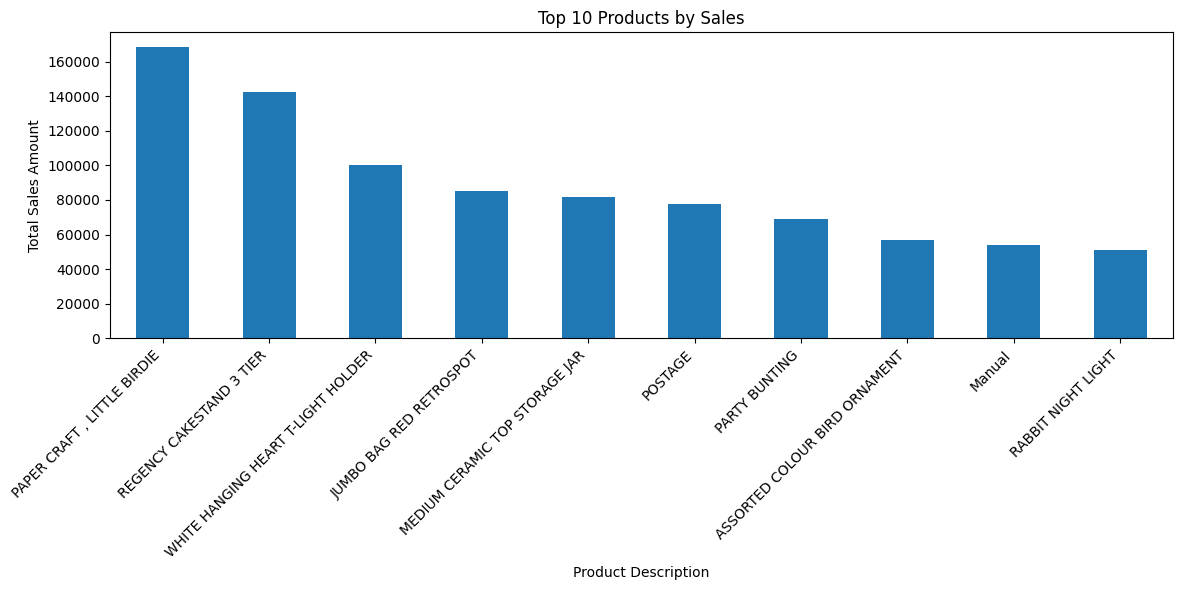

In [18]:
# 5. Top 10 products by sales
top_products = df.groupby('Description')['TotalAmount'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))
top_products.plot(kind='bar')
plt.title('Top 10 Products by Sales')
plt.xlabel('Product Description')
plt.ylabel('Total Sales Amount')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

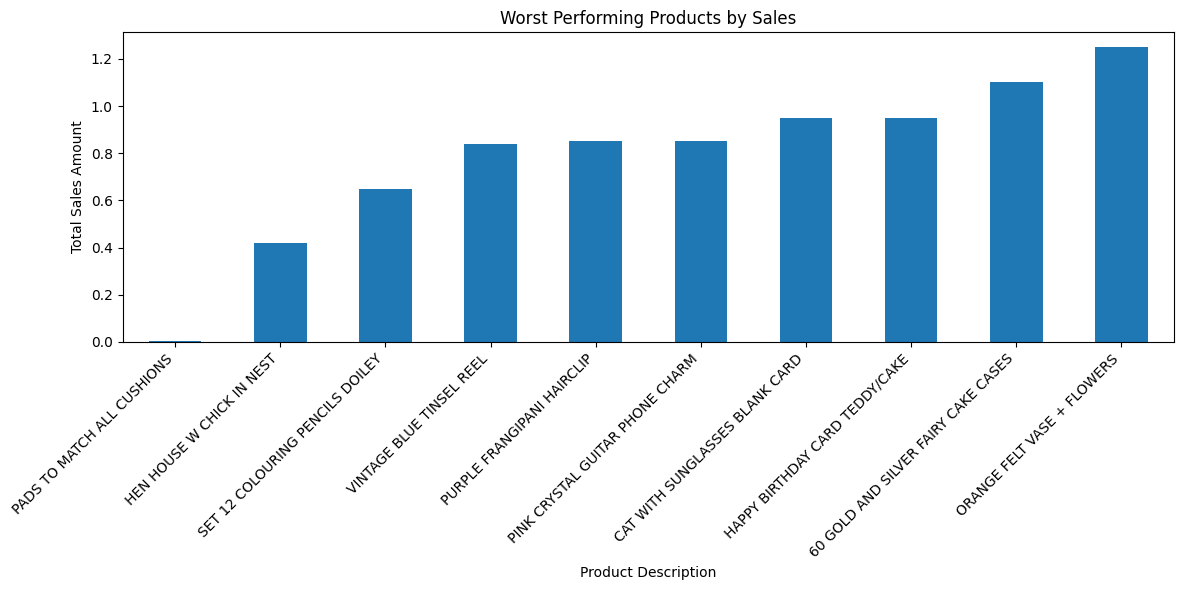

In [19]:
# 6. Worst performing products by sales
worst_products = df.groupby('Description')['TotalAmount'].sum().sort_values(ascending=True).head(10)
plt.figure(figsize=(12, 6))
worst_products.plot(kind='bar')
plt.title('Worst Performing Products by Sales')
plt.xlabel('Product Description')
plt.ylabel('Total Sales Amount')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

In [20]:
# Print some key insights
print(f"Total number of customers: {len(customer_metrics)}")
print(f"Customer segment distribution:\n{customer_metrics['Customer_Segment'].value_counts(normalize=True)}")
print(f"Average monetary value by segment:\n{avg_monetary}")
print(f"Total revenue: ${customer_metrics['Monetary'].sum():,.2f}")
print(f"Top selling product: {top_products.index[0]} (${top_products.iloc[0]:,.2f})")
print(f"Worst selling product: {worst_products.index[0]} (${worst_products.iloc[0]:,.2f})")

Total number of customers: 4338
Customer segment distribution:
Customer_Segment
Other                  0.419548
Best Customers         0.175426
Loyal Customers        0.168050
Lost Customers         0.151913
Low-Value Customers    0.085062
Name: proportion, dtype: float64
Average monetary value by segment:
Customer_Segment
Best Customers         6302.178357
Loyal Customers        2323.780331
Other                  1113.241177
Lost Customers          504.437405
Low-Value Customers     170.436640
Name: Monetary, dtype: float64
Total revenue: $8,911,407.90
Top selling product: PAPER CRAFT , LITTLE BIRDIE ($168,469.60)
Worst selling product: PADS TO MATCH ALL CUSHIONS ($0.00)
